# Building Autoencoders in ~~Keras~~ PyTorch

WNixalo – 2018/6/16-20

[Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch

In [3]:
import matplotlib.pyplot as plt

In [4]:
import copy

## 1. Building the simplest possible autoencoder

> We'll start simple, with a single fully-connected neural layer as encoder and as decoder:

```
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32 # 32 floats -> compression of factor 24.5 assuming input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
```

> Let's also create a separate encoder model:

```
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)
```
> As well as the decoder model:

```
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
```

In [5]:
import torch.nn as nn
import torch.nn.functional as F

In [6]:
input_size   = 784
encoding_dim = 32

In [7]:
# writing full classes for the en/de-coders is overkill, but this is the 
# general form of writing pytorch modules.

class Encoder(nn.Module):
    def __init__(self, input_size, encoding_dim):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(input_size, encoding_dim), nn.ReLU()])
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
            
class Decoder(nn.Module):
    def __init__(self, encoding_dim, input_size):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(encoding_dim, input_size)])
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class Autoencoder(nn.Module):
    def __init__(self, input_size=784, encoding_dim=32):
        super().__init__()
        self.encoder = Encoder(input_size, encoding_dim)
        self.decoder = Decoder(encoding_dim, input_size)
    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten to (nm,1) vector
        x = self.encoder(x)  # Encode
        x = self.decoder(x)  # Decode
        x = F.sigmoid(x)
        x = x.reshape(x.size(0),1,28,28) # should be a more elegant way to do this
        return x

In [8]:
autoencoder = Autoencoder(784, 32)

> Now let's train our autoencoder to reconstruct MNIST digits.
>
> First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:

```
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
```

> Let's prepare our input data. We're using MNIST digits, and we're discarding the labels (since we're only interested in encoding/decoding the input images).

```
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()
```

> We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.

```
x_train = x_train.astype('float32') / 255.
x_test  = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test  = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)
```

In [10]:
# # these are actually initialized within the training loop
# optimizer = torch.optim.Adadelta(autoencoder.parameters())
# criterion = torch.nn.BCELoss()

In [8]:
import torchvision

In [9]:
bs = 16

# stats = [[0.1307],[0.3073]] # calculated from training set

tfm0 = torchvision.transforms.ToTensor()  # convert [0,255] -> [0.0,1.0]
# tfm1 = torchvision.transforms.Normalize(*stats) # normalize to [-1.0,+1.0]

# tfms = [tfm0, tfm1]
# tfms = torchvision.transforms.Compose(tfms)

In [10]:
train_dataset = torchvision.datasets.MNIST('data/MNIST/',train=True, transform=tfm0)
test_dataset  = torchvision.datasets.MNIST('data/MNIST/',train=False,transform=tfm0)

train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_loader   = torch.utils.data.DataLoader(test_dataset,  batch_size=bs)

---

### Aside: Flattening Tensors and Untrained Autoencoder output

multiple ways to flatten tensors:

In [10]:
# get minibatch
x,_ = next(iter(train_loader)); x_test,_ = next(iter(test_loader))
# check ea. way to flatten is identical
compare0 = torch.equal(np.reshape(x, (len(x), np.prod(x.shape[1:]))),
                       x.reshape(len(x), np.prod(x.shape[1:])))
compare1 = torch.equal(x.view(x.size(0), -1), x.reshape(len(x), np.prod(x.shape[1:])))
print(True == compare0 == compare1)
# display flattened minibatch shapes
print(x.view(x.size(0), -1).shape)
print(x_test.view(x_test.size(0), -1).shape)

True
torch.Size([16, 784])
torch.Size([16, 784])


Here's a test of the autoencoder without any training (you'd expect just noise):

In [13]:
x,y = next(iter(train_loader))
z = autoencoder(x)

In [14]:
z.shape

torch.Size([16, 1, 28, 28])

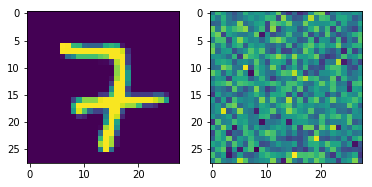

In [197]:
fig,axes = plt.subplots(1,2); plt.set_cmap(['gray','viridis'][1]);
axes[0].imshow(x[0][0].numpy()); axes[1].imshow(z[0][0].detach().numpy());

In [11]:
def compare_plot(x,z, idx=0, cdx=1):
    """assumes x,y (bs,1,28,28) tensors"""
    fig,axes = plt.subplots(1,2); plt.set_cmap(['gray','viridis'][cdx]);
    if type(z) == torch.Tensor: z = z.detach().numpy()
    axes[0].imshow(x[idx][0].numpy()); axes[1].imshow(z[idx][0]);

---

> Now let's train our autoencoder for 50 epochs:

```
autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True,
                validation_data=(x_test, x_test))
```

> After 50 epochs, the autoencoder seems to reach a stable train/test loss value of about `0.11`. We can try to visualize the reconstrubted inputs and the encoded representations. We will use Matplotlib.

```
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
```

```
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10 # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
```

In [12]:
def train(model, trainloader=None, valloader=None, num_epochs=1):
    # use GPU0 if available # pytorch >= 0.4
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    # name dataloaders for phases
    phases = ['train']
    dataloaders = {'train':trainloader}
    if valloader:
        phases.append('valid')
        dataloaders['valid'] = valloader
    
    # move model to gpu -- pytorch >= 0.4 ## NOTE: havent tested on gpu yet
    model.to(device)
    optimizer = torch.optim.Adadelta(autoencoder.parameters())
    criterion = torch.nn.BCELoss()
    
    # epoch w/ train & val phases
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}\n{"-"*10}')
        
        for phase in phases:
            if phase == 'train':
                #scheduler.step() # (no LR scheduler this time)
                model.train() # set model to training mode
            else: model.eval() # set model to evaluation mode
                
            running_loss, running_correct, count = 0.0, 0, 0
        
            for i, minibatch in enumerate(dataloaders[phase]):
                x,y = minibatch
                x,y = x.to(device), y.to(device)

                # zero param gradients
                optimizer.zero_grad()

                # forward: track history if training phase
                with torch.set_grad_enabled(phase=='train'): # pytorch >= 0.4
                    outputs = model(x)
                    loss    = criterion(outputs, x)
                    preds,_ = torch.max(outputs,1) # for accuracy metric
                    # backward & optimize if training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # stats
                running_loss += loss.item() * x.size(0)
                count += len(x)
            
            epoch_loss = running_loss / count
            print(f'{phase} loss {epoch_loss:.6f}')
        print()

In [205]:
%time train(autoencoder, trainloader=train_loader, valloader=test_loader, num_epochs=1)

Epoch 1/1
----------
CPU times: user 54.4 s, sys: 1.3 s, total: 55.7 s
Wall time: 19.7 s


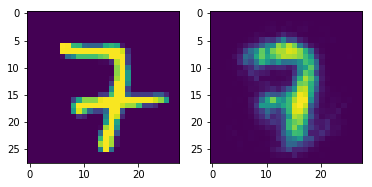

In [211]:
x,y = next(iter(train_loader))
z = autoencoder(x)
compare_plot(x,z)

Woah.

---

### Aside: Fast.AI

FChollet makes use of TensorBoard to make some fancy plots of the training process. Also, Keras isn't at PyTorch's abstraction level: PyTorch is comparable to TensorFlow, Keras' backend. So instead of doing all my training manually, I'm going to modify the pytorch dataloaders a bit so I can use them with fastai for training. This'll give me some powerful high-level control over the process.

In [13]:
# create copies of dataloaders for ModelData
train_loadermd = copy.deepcopy(train_loader)
test_loadermd  = copy.deepcopy(test_loader)

# set y to be x and convert [0,255] int to [0.0,1.0] float. (dl doesnt trsfm `y` by default)
train_loadermd.dataset.train_labels = train_loadermd.dataset.train_data.type(torch.FloatTensor)/255
test_loadermd.dataset.test_labels   = test_loadermd.dataset.test_data.type(torch.FloatTensor)/255

# add channel dimension for compatibility. (bs,h,w) –> (bs,ch,h,w)
train_loadermd.dataset.train_labels = train_loadermd.dataset.train_labels.reshape((len(train_loadermd.dataset),1,28,28))
test_loadermd.dataset.test_labels   = test_loadermd.dataset.test_labels.reshape((len(test_loadermd.dataset),1,28,28))

In [14]:
from fastai.conv_learner import *

In [15]:
md = ModelData('data/MNIST', train_loadermd, test_loadermd)

In [20]:
learn = Learner.from_model_data(Autoencoder(), md)
learn.crit = F.binary_cross_entropy

epoch      trn_loss   val_loss                                  
    0      0.142973   0.154716  


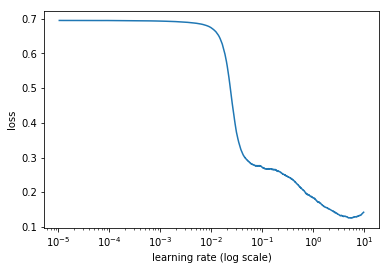

In [174]:
learn.lr_find()
learn.sched.plot()

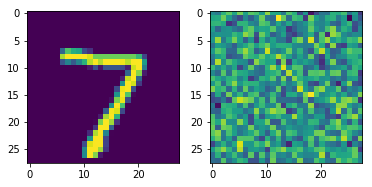

In [175]:
z = learn.predict()        # run learner on val data
x = md.val_ds.test_data[0] # get X from val dataset
compare_plot([[x]], z) # expects dims: (batchsize, channels, rows, cols)

epoch      trn_loss   val_loss                                  
    0      0.264682   0.262922  


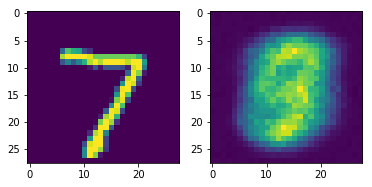

In [176]:
learn.fit(0.01, 1)     # fit learner to data
z = learn.predict()    # run learner on val data
compare_plot([[x]], z) # display X vs Z

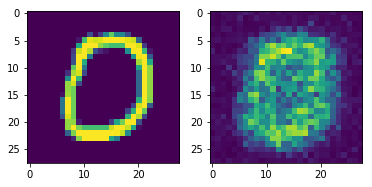

In [188]:
x = md.val_ds.test_data.reshape(len(md.val_ds),1,28,28)
compare_plot(x, z, idx=10)

---

Now that I got fastai working with the data, I can easily train 50 epochs. Although, to show how quickly the model converges w/ MNIST data, here's the result of a couple epochs via pure-pytorch:

In [221]:
autoencoder = Autoencoder()
train(autoencoder, train_loader, test_loader, num_epochs=2)

Epoch 1/2
----------
train loss 0.200236
valid loss 0.148270

Epoch 2/2
----------
train loss 0.131812
valid loss 0.117702



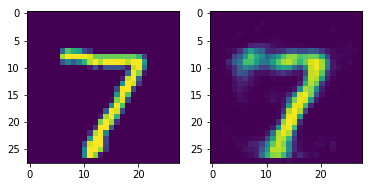

In [223]:
x,y = next(iter(test_loader))
z = autoencoder(x)
compare_plot(x, z)

Now to train for 50 epochs with fastai:

In [242]:
autoencoder = Autoencoder()
learner = Learner.from_model_data(autoencoder, md)
learner.crit = F.binary_cross_entropy
learner.opt_fn = torch.optim.Adadelta

epoch      trn_loss   val_loss                                 
    0      0.180425   0.171059  


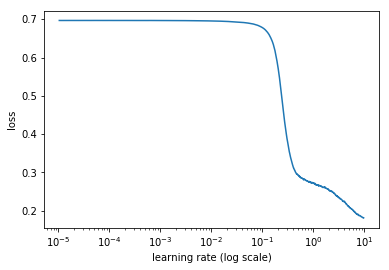

In [243]:
learner.lr_find()
learner.sched.plot()

Looks like I'll have to use a really aggressive learning rate just to get started anywhere. The `torch.optim.Adadelta` optimizer's default was `1.0` in the pytorch training loop. I'm training for 50 epochs anyway (to match the tutorial) so I'll go with `0.5`. The tutorial is also using batch sizes of 256, but I'm using 16 (for no particular reason than not wanting to reinitialize everything).

Nothing special with training: just 50 cycles, each 1 epoch long, using default [Cosine Annealing](https://arxiv.org/abs/1608.03983), no weight decay. 

In [245]:
learner.fit(0.5, n_cycle=50)

epoch      trn_loss   val_loss                                 
    0      0.180503   0.179986  
    1      0.146636   0.145664                                 
    2      0.127929   0.126243                                 
    3      0.116537   0.114927                                 
    4      0.110755   0.108692                                 
    5      0.106966   0.105151                                 
    6      0.104011   0.102819                                 
    7      0.102981   0.101205                                 
    8      0.100336   0.099909                                  
    9      0.101887   0.099023                                   
    10     0.10073    0.098413                                   
    11     0.098454   0.097746                                   
    12     0.099941   0.097324                                   
    13     0.096887   0.096923                                   
    14     0.097922   0.096655                              

[0.09377471673488617]

In [246]:
learn.save('pytorch-autoencoder-50ep')

In [263]:
x,y = next(iter(md.val_dl)) # get 1st minibatch
z = learner.predict()

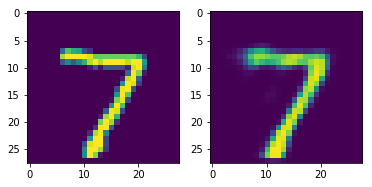

In [266]:
compare_plot(x,z)

In [16]:
def compare_batch(x, z, bs=16, figsize=(16,2)):
    bs = min(len(x), bs) # digits to display
    fig = plt.figure(figsize=figsize)
    for i in range(bs):
        # display original
        ax = plt.subplot(2, bs, i+1); ax.imshow(x[i].reshape(28,28))
        ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
        
        # display reconstruction
        ax = plt.subplot(2, bs, i+1+bs); ax.imshow(z[i].reshape(28,28))
        ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)

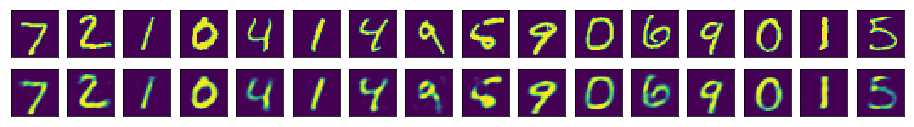

In [286]:
compare_batch(x,z)

> Here's what we get. The top row is the original digits, and the bottom row is the reconstructed digits. We are losing quite a bit of detail with this basic approach.

<img src="https://blog.keras.io/img/ae/basic_ae_32.png">

## 2. Adding a sparsity constraint on the encoded representations

> In the previous example, the representations were only constrained by the size of the hidden layer (32). In such a situation, what typically ahppens is that the hidden layer is learning an approximation of [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) [(principal component analysis)](https://en.wikipedia.org/wiki/Principal_component_analysis). But another way to constrain the representations to be compact is to add a sparsity constraint on the activity of the hidden representations, so fewer units would "fire" at a given time. In Keras, this can be done by adding an `activity_regularizer` to our `Dense` layer:

```
from keras import regularizers

encoding_dim = 32

input_img = Input(shape=(784,))
# add a Dense layer with a L1 activity regularizer
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)
```

> Let's train this model for 100 epochs (with the added regularization the model is less likely to overfit and can be trained longer). The model ends with a train loss of `0.11` and a test loss of `0.10`. The difference between the two is mostly due to the regularization term being added to the loss during training (worth about 0.01).

Fast AI's Learner has a built-in regularization function attribute. 

Internally in `fastai.model.Stepper` in the `step(.)` function, the `output` is calculated by passing the input/s into the model `self.m(.)`. If the `output` is a tuple, in the case of multi-headed models or models that also output intermediate activations, `output` is reassigned and destructured: `output` is reassigned to it's 1st item, and `xtra` is a list of all the rest.

`raw_loss` is first calculated on the `output` and `y` using the loss function `self.crit`. If no regularization function is attached to the Learner, the `raw_loss` is returned as the loss. Otherwise, `output`, `xtra`, and `raw_loss` are all passed into the regularizer `self.reg_fn` and the result is returned as loss.

So adding L1 (or any) regularization to a Fast AI Learner is as easy as defining a regularization function that accepts arguments: `output, xtra, raw_loss` and assigning it to `learner.reg_fn`. Also make sure the encoder sends a copy of it

This raises a further question of how exactly was multi-head / output work done, for example in [pascal.ipynb](https://github.com/fastai/fastai/blob/master/courses/dl2/pascal-multi.ipynb) (multi-head multi-output) and [lesson2-image_models.ipynb](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson2-image_models.ipynb) (multi-output). In lesson2-image_models that abstraction layer is still hidden, but in pascal.ipynb the SSD model's `OutConv` nn.Module class outputs a *`list`* of [classifications, regressions], so I think that's the big clue. I tested this and the output indeed didn't get destructured.

In [17]:
# writing full classes for the en/de-coders is overkill, but this is the 
# general form of writing pytorch modules.

class EncoderL1(nn.Module):
    def __init__(self, input_size, encoding_dim):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(input_size, encoding_dim), nn.ReLU()])
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
            
class Decoder(nn.Module):
    def __init__(self, encoding_dim, input_size):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(encoding_dim, input_size)])
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class AutoencoderL1(nn.Module):
    """Basic autoencoder with extra encoder output for L1 regularization."""
    def __init__(self, input_size=784, encoding_dim=32):
        super().__init__()
        self.encoder = EncoderL1(input_size, encoding_dim)
        self.decoder = Decoder(encoding_dim, input_size)
    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten to (nm,1) vector
        l1x = self.encoder(x)  # Encode
        x = self.decoder(l1x)  # Decode
        x = F.sigmoid(x)
        x = x.reshape(x.size(0),1,28,28) # should be a more elegant way to do this
        return x, l1x # autoencoder and encoder outputs
    
def l1_reg(output, xtra, raw_loss, λ1=1e-4):
    """Adds L1 Regularization to the Loss."""
    return λ1*torch.abs(*xtra).sum() + raw_loss # xtra comes in as list, deconstruct to tensor

In [28]:
learn = Learner.from_model_data(AutoencoderL1(), md)

In [29]:
learn.crit = F.binary_cross_entropy
learn.opt_fn = torch.optim.Adadelta
learn.reg_fn = l1_reg

epoch      trn_loss   val_loss                                 
    0      0.246507   0.239414  


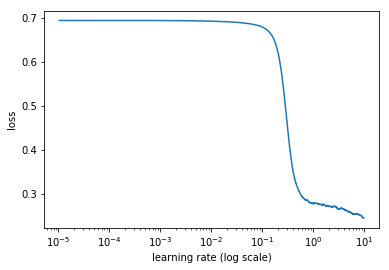

In [30]:
learn.lr_find()
learn.sched.plot()

In [31]:
%time learn.fit(0.5, 100) # same lr as before; now 100 cycles (1 ep/cyc)

epoch      trn_loss   val_loss                                 
    0      0.250728   0.248423  
    1      0.231891   0.231998                                 
    2      0.224072   0.220726                                 
    3      0.218669   0.21725                                  
    4      0.217783   0.21568                                  
    5      0.214344   0.214774                                 
    6      0.214792   0.213973                                 
    7      0.214472   0.21356                                  
    8      0.215391   0.213021                                 
    9      0.214764   0.212651                                 
    10     0.213261   0.212288                                 
    11     0.215662   0.212235                                 
    12     0.215801   0.211687                                 
    13     0.213287   0.211712                                 
    14     0.212363   0.211242                                 
    15 

[0.190795294547081]

I think my learning rate was too low with the added regularization. And I just realized since this is pytorch I could have the model output the encoder outputs for regularization *only* when in training mode. *hmm*, next time.

In [36]:
learn.save('autoencoder_l1reg_100ep')

In [69]:
x = next(iter(learn.data.val_dl))[0]
z = learn.predict()

In [72]:
z.shape, x.shape

((10000, 1, 28, 28), torch.Size([16, 1, 28, 28]))

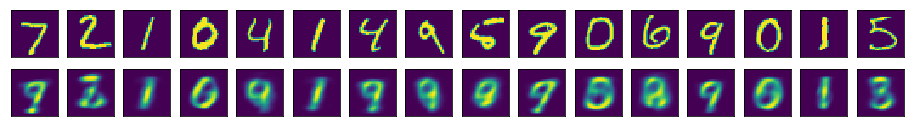

In [71]:
compare_batch(x, z)

> Here's a visualization of our new results:

<img src="https://blog.keras.io/img/ae/sparse_ae_32.png" >

> They look pretty similar to the previous model, the only significant difference being the sparsity of the encoded representations. `encoded_imgs.mean()` yields a value `3.33` (over our 10,000 test images), whereas with the previous model the same quantity was `7.30`. So our new model yields encoded representations that are twice sparser.

In [104]:
encodings = [] # now its convenient Im getting the encoder's output
for x,_ in iter(learn.data.val_dl):
    encodings.append(learn.model(x)[1].detach().numpy().mean())
np.array(encodings).mean()

0.18292214

## 3. Deep autoencoder

> We do not have to limit ourselves to a single layer as encoder or decoder, we could instead use a stack of layers such as:

```
input_img = Input(shape(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64,  activation='relu')(encoded)
encoded = Dense(32,  activation='relu')(encoded)

decoded = Dense(64,  actication='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)
```

> Let's try this:

```
autoencoder = Model(inpu_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train, epochs=100, batch_size=256, shuffle=True, 
                validation_data=(x_test, x_test))
```

In [18]:
# writing with list comprehensions easily allows for arbitrary-depth networks
# Also I totally forgot the ReLU activations.
class EncoderBlock(nn.Module):
    def __init__(self, input_size=784, encoding_dim=32, n_layers=3):
        super().__init__()
        layers =  [nn.Linear(input_size, encoding_dim*2**(n_layers-1))]
        layers += [nn.Linear(encoding_dim*2**(i), encoding_dim*2**(i-1)) for i in range(n_layers-1,0,-1)]
        self.layers = nn.Sequential(*layers)
    def forward(self, x):
        return self.layers(x)

class DecoderBlock(nn.Module):
    def __init__(self, output_size=784, encoding_dim=32, n_layers=3):
        super().__init__()
        layers =  [nn.Linear(encoding_dim*2**(i), encoding_dim*2**(i+1)) for i in range(n_layers-1)]
        layers += [nn.Linear(encoding_dim*2**(n_layers-1), output_size)]
        self.layers = nn.Sequential(*layers)
    def forward(self, x):
        return self.layers(x)

class DeepAutoencoder(nn.Module):
    def __init__(self, input_size=784, encoding_dim=32, n_layers=3):
        super().__init__()
        self.encoder = EncoderBlock(input_size, encoding_dim, n_layers)
        self.decoder = DecoderBlock(input_size, encoding_dim, n_layers)
    def forward(self, x):
        x = x.view(x.size(0), -1)     # flatten
        enc_x = self.encoder(x)          # encode
        x = self.decoder(enc_x)          # decode
        x = F.sigmoid(x)                 # activtn
        x = x.reshape(x.size(0),1,28,28) # 'unflatten'
        return x, enc_x # also return encoding

In [96]:
learn = Learner.from_model_data(DeepAutoencoder(), md)

In [97]:
learn.crit  = F.binary_cross_entropy
learn.optim = torch.optim.Adadelta

 86%|████████▋ | 3238/3750 [00:54<00:08, 59.78it/s, loss=0.751]

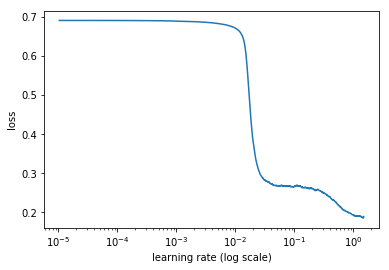

 86%|████████▋ | 3238/3750 [01:05<00:10, 49.61it/s, loss=0.751]

In [98]:
learn.lr_find()
learn.sched.plot()

In [99]:
learn.fit(0.5, 100)

epoch      trn_loss   val_loss                                  
    0      0.120986   0.117343  
    1      0.109043   0.10734                                   
    2      0.104469   0.102813                                  
    3      0.101269   0.099745                                   
    4      0.100716   0.098699                                   
    5      0.099753   0.09749                                   
    6      0.097745   0.096033                                  
    7      0.097524   0.095729                                   
    8      0.096915   0.096204                                   
    9      0.097093   0.094898                                   
    10     0.096377   0.094045                                   
    11     0.095779   0.094725                                   
    12     0.095585   0.094494                                   
    13     0.096055   0.093822                                   
    14     0.094103   0.09436                   

[0.09385320316553115]

In [100]:
learn.save('autoencoder_deep_100ep')

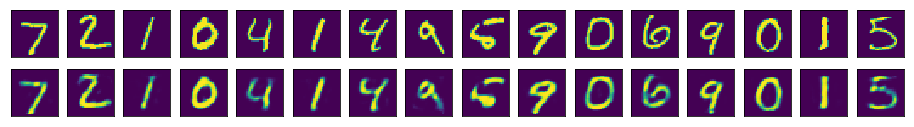

In [102]:
x,y = next(iter(learn.data.val_dl))
z   = learn.predict()
compare_batch(x,z)

> After 100 epochs, it reaches a train and test loss of ~0.097, a bit better than our previous models. Our reconstructed digits look a bit better too:

<img src="https://blog.keras.io/img/ae/deep_ae_32.png">

## 4. Convolutional autoencoder

> Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders –– they simple perform much better.
>
> Let's implement one. The encoder will consist in a stack of `Conv2D` and `MaxPooling2D` layers (max pooling being used for spatial down-sampling), while the decoder will conssit in a stack of `Conv2D` and `UpSampling2D` layers.

```
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1)) # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D(2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu' padding='same')(x)
x = MaxPooling2D(2, 2), padding='same'(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D(2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2d(2, 2)(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
```

> To train it, we will use the original MNIST digits with shape `(samples, 3, 28, 28)`, and we will just normalize pixel values between 0 and 1.

```
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) # adapt this if using `channels_first` image data format
x+test = np.reshape(x_test, (len(x_test), 28, 28, 1)) # adapt this if using `channels_first` image data format
```

> Let's train this model for 50 epochs. For the sake of demonstrating how to visualize the results of a model during training, we will be using [the TensorFlow backend](https://blog.keras.io/building-autoencoders-in-keras.html) and the TensorBoard callback.
>
> First let's open up a terminal and start a TensorBoard server that will read logs stored at `/tmp/autoencoder`.

> Then let's train our model. In the `callbacks` list we pass an instance of the `TensorBoard` callback. After every epoch, this callback will write logs to `/tmp/autoencoder`, which can be read by our TensorBoard server.

```
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train, epochs=50, batch_size=128, shuffle=True, 
                validation_data=(x_test, x_test), 
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])
```

> This allows us to monitor training in the TensorBoard web interface (by navigating to `http://0.0.0.0:6006`):

<img src="https://blog.keras.io/img/ae/tb_curves.png" >

In [19]:
class ConvEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(1, 16, 3)
        self.conv1 = nn.Conv2d(16, 8, 3)
        self.conv2 = nn.Conv2d(8,  8, 3)
    def forward(self, x):
        x = F.pad(x, (1,1,1,1), mode='replicate') # pad
        x = F.relu(self.conv0(x))                 # conv & actvn (1,16,28,28)
        x = F.max_pool2d(x, 2)                    # pool         (1,16,14,14)
        x = F.pad(x, (1,1,1,1), mode='replicate') # pad
        x = F.relu(self.conv1(x))                 # conv & actvn (1, 8,14,14)
        x = F.max_pool2d(x, 2)                    # pool         (1, 8, 7, 7)
        x = F.pad(x, (1,1,1,1), mode='replicate') # pad
        x = F.relu(self.conv2(x))                 # conv & actvn (1, 8, 7, 7)
        x = F.pad(x, (1,1,1,1), mode='replicate') # pad
        x = F.max_pool2d(x, 2)                    # pool         (1, 8, 4, 4)
        return x
    
class ConvDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(8, 8, 3)
        self.conv1 = nn.Conv2d(8, 8, 3)
        self.conv2 = nn.Conv2d(8, 16,3)
        self.conv3 = nn.Conv2d(16, 1,3)
        self.upsample = nn.Upsample(scale_factor=2)
    def forward(self, x):
        x = F.pad(x, (1,1,1,1), mode='replicate') # pad
        x = F.relu(self.conv0(x))                 # conv & actvn (1, 8, 4, 4)
        x = self.upsample(x)                      # upsample     (1, 8, 8, 8)
        x = F.pad(x, (1,1,1,1), mode='replicate') # pad
        x = F.relu(self.conv1(x))                 # conv & actvn (1, 8, 8, 8)
        x = self.upsample(x)                      # upsample     (1, 8,16,16)
        x = F.relu(self.conv2(x))                 # conv & actvn (1,16,14,14)
        x = self.upsample(x)                      # upsample     (1,16,28,28)
        x = F.pad(x, (1,1,1,1), mode='replicate') # pad
        x = F.sigmoid(self.conv3(x))              # conv & actvn (1, 1,28,28)
        return x

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = ConvEncoder()
        self.decoder = ConvDecoder()
    def forward(self, x):
        enc_x = self.encoder(x)
        x = self.decoder(enc_x)
        return x, enc_x

I'm going to use the same MNIST data I've been using.

In [306]:
learn = Learner.from_model_data(ConvAutoencoder(), md)

In [307]:
learn.opt_fn = torch.optim.Adadelta
learn.crit   = F.binary_cross_entropy

epoch      trn_loss   val_loss                                 
    0      0.194118   0.198236  


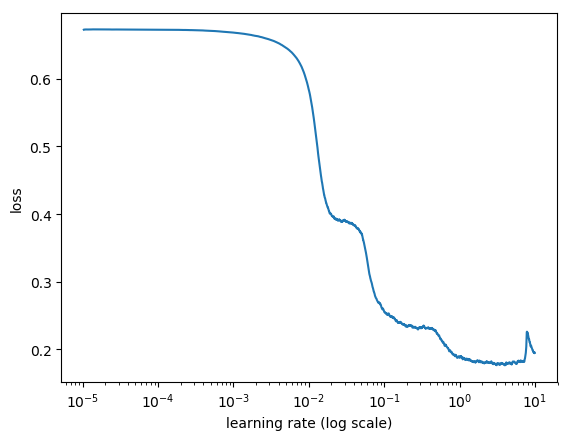

In [308]:
learn.lr_find()
learn.sched.plot(n_skip_end=0)

In [318]:
%time learn.fit(0.1, 50) # 50 1-epoch cycles at lr=0.1

epoch      trn_loss   val_loss                                 
    0      0.150967   0.150391  
    1      0.12907    0.133564                                 
    2      0.122344   0.119396                                 
    3      0.114795   0.113412                                 
    4      0.113377   0.112516                                 
    5      0.109648   0.108521                                 
    6      0.1075     0.106346                                 
    7      0.105783   0.105214                                 
    8      0.104533   0.102116                                 
    9      0.102351   0.101962                                 
    10     0.103103   0.101578                                 
    11     0.101052   0.100249                                  
    12     0.101315   0.099082                                  
    13     0.09977    0.098173                                  
    14     0.100634   0.097466                                  
   

[0.09073325432538987]

In [319]:
learn.save('autoencoder_conv_50ep')

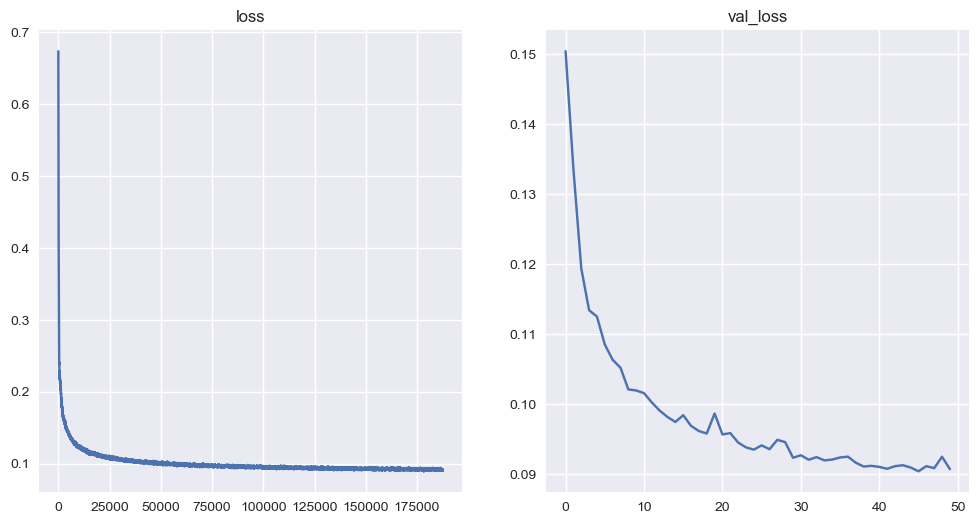

In [320]:
plt.style.use('seaborn')
fig = plt.figure(figsize=(12,6));
ax = plt.subplot(1, 2, 1); ax.plot(learn.sched.losses); ax.set_title('loss')
ax = plt.subplot(1, 2, 2); ax.plot(learn.sched.val_losses); ax.set_title('val_loss');

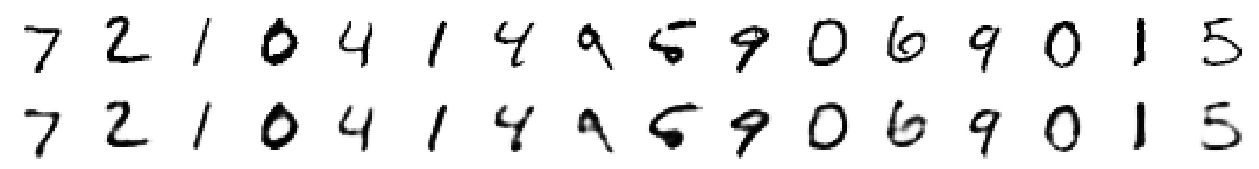

In [321]:
x,y = next(iter(learn.data.val_dl))
z   = learn.predict()
compare_batch(x,z)

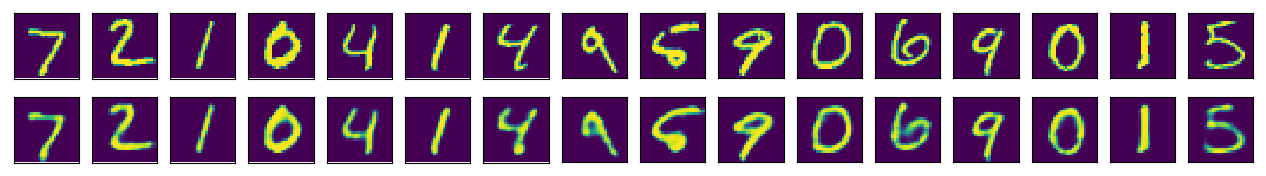

In [322]:
plt.style.use('default')
compare_batch(x,z)

> The model converges to a loss of `0.094`, significantly better than our previous models (this is in large part due to the higher entropic capacity of the encoded representation, 128 deimensions vs. 32 previously). Let's take a look at the reconstructd digits:

<img src="https://blog.keras.io/img/ae/deep_conv_ae_128.png">

> We can also have a look at the 128-dimensional encoded representations. These representations are 8x4x4, so we reshape them to 4x32 in order to eb able to display them as grayscale images.

<img src="https://blog.keras.io/img/ae/encoded_representations.png">

In [323]:
encodings = learn.model(x)[1]

In [324]:
encodings.shape

torch.Size([16, 8, 4, 4])

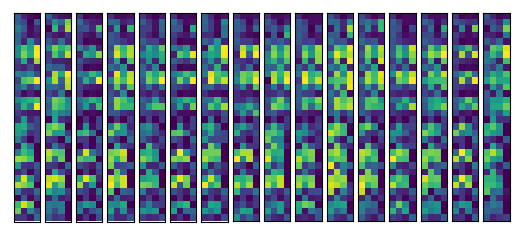

In [336]:
for i in range(bs):
    ax = plt.subplot(1, bs, i+1); ax.imshow(encodings[i].reshape(4,4*8).detach().numpy().T)
    ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)

## 5. Application to image denoising

> Let's put our convolutional autoencoder to work on an image denoising problem. It's simple: we will train the autoencoder to map noisy digits images to clean digits images.
>
>Here's how we will generate synthetic noisy digits: we just apply a gaussian noise matrix and clip the images between 0 and 1.

```
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) # adapt this if using `channels_first` data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1)) # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
```

> Here's what the noisy digits look like:

<img src="https://blog.keras.io/img/ae/noisy_digits.png">

Luckily for me, thanks to Fast.AI and PyTorch, all I need to do is update the dataset's transform and I can get straight back to work. I just need a transform that adds noise. I can use Pytorch's [Lambda transform](https://github.com/pytorch/vision/blob/master/torchvision/transforms/transforms.py#L281) to define my own. I guess I should use [pytorch's torch.randn](https://github.com/pytorch/vision/blob/master/torchvision/transforms/transforms.py#L281) function instead of numpy's.

On second thought, aren't transforms done on the cpu anyway? I'm trying to think about writing generalizable code; in anycase, getting more comfortable with pytorch is a good thing.

In [388]:
def add_noise(tensor, noise_factor=0.3):
    return tensor + noise_factor * torch.randn(tensor.shape)

tfm0 = torchvision.transforms.ToTensor()
tfm1 = torchvision.transforms.Lambda(add_noise)

tfms = torchvision.transforms.Compose([tfm0, tfm1])

learn.data.trn_ds.transform = tfms
learn.data.val_ds.transform = tfms

And let's take a look at our new noisified data (0.5 noise factor):

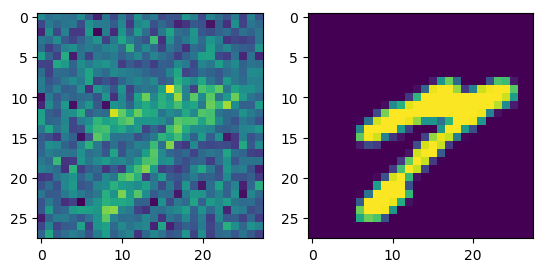

In [382]:
x,y = next(iter(learn.data.trn_dl))
compare_plot(x,y)

Okay.. way too much noise 😅

Here's noise factor 0.3:

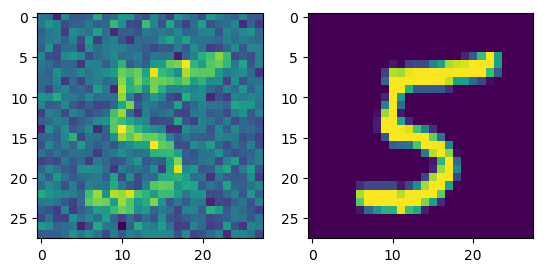

In [389]:
x,y = next(iter(learn.data.trn_dl))
compare_plot(x,y)

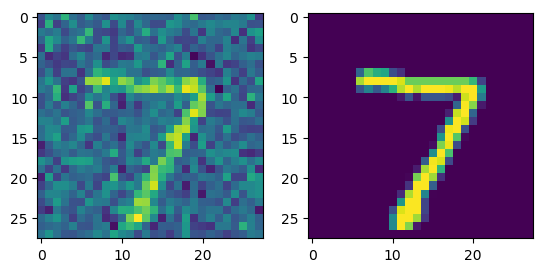

In [390]:
compare_plot(*next(iter(learn.data.val_dl)))

>If you squint you can still recognize them, but barely. Can our autoencoder learn to recover the original digits? Let's find out.
>
>Compared to the previous convolutional autoencoder, in order to improve the quality of the reconstructed, we'll use a slighly different model with more filters per layer:

```
input_img = Input(shape=(28, 28, 1) # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
```

My Mac is going to *love* this.

In [20]:
class ConvEncoderDenoise(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(1,  32, 3)
        self.conv1 = nn.Conv2d(32, 32, 3)
    def forward(self, x):
        x = F.pad(x, (1,1,1,1), mode='replicate') # pad
        x = F.relu(self.conv0(x))                 # conv & actvn (bs,32,28,28)
        x = F.max_pool2d(x, 2)                    # pool         (bs,32,14,14)
        x = F.pad(x, (1,1,1,1), mode='replicate') # pad
        x = F.relu(self.conv1(x))                 # conv & actvn (bs, 32,14,14)
        x = F.max_pool2d(x, 2)                    # pool         (bs, 32, 7, 7)
        return x
    
class ConvDecoderDenoise(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(32, 32, 3)
        self.conv1 = nn.Conv2d(32, 32, 3)
        self.conv2 = nn.Conv2d(32, 1,  3)
        self.upsample = nn.Upsample(scale_factor=2)
    def forward(self, x):
        x = F.pad(x, (1,1,1,1), mode='replicate') # pad
        x = F.relu(self.conv0(x))                 # conv & actvn (bs,32, 7, 7)
        x = self.upsample(x)                      # upsample     (bs,32,14,14)
        x = F.pad(x, (1,1,1,1), mode='replicate') # pad
        x = F.relu(self.conv1(x))                 # conv & actvn (bs,32,14,14)
        x = self.upsample(x)                      # upsample     (bs,32,28,28)
        x = F.pad(x, (1,1,1,1), mode='replicate') # pad
        x = F.sigmoid(self.conv2(x))              # conv & actvn (bs, 1,28,28)
        return x

class ConvAutoencoderDenoise(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = ConvEncoderDenoise()
        self.decoder = ConvDecoderDenoise()
    def forward(self, x):
        enc_x = self.encoder(x)
        x = self.decoder(enc_x)
        return x, enc_x

In [393]:
learn = Learner.from_model_data(ConvAutoencoderDenoise(), md)
learn.crit = F.binary_cross_entropy
learn.opt_fn = torch.optim.Adadelta

epoch      trn_loss   val_loss                                 
    0      0.125226   0.137232  


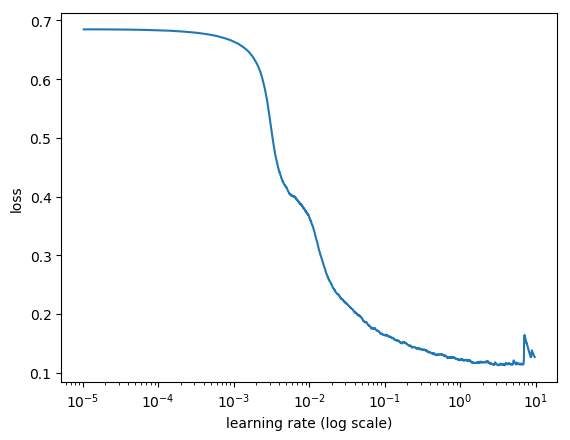

In [394]:
learn.lr_find()
learn.sched.plot()

I did something with pyplot and it made the plots bigger. Ah well. 0.2 Learning rate looks alright. FChollet does this for a 100 epochs.. since I don't want to save-gitpush-gitpull-restart this notebook to run on a AWS GPU instance, I'll leave this to run through the night on my Mac. *hopefully that's not an irresponsible way to treat my hardware...*

In [396]:
learn.fit(0.2, 100) # lr=0.2 for 100 1-epoch cycles

epoch      trn_loss   val_loss                                  
    0      0.089942   0.089385  
    1      0.084569   0.084538                                  
    2      0.083804   0.083029                                  
    3      0.082711   0.081791                                  
    4      0.082448   0.080888                                  
    5      0.081158   0.080789                                  
    6      0.079876   0.080174                                  
    7      0.081274   0.079656                                  
    8      0.080663   0.07931                                   
    9      0.079917   0.07908                                   
    10     0.080253   0.07902                                   
    11     0.080176   0.07879                                   
    12     0.079051   0.078726                                  
    13     0.078867   0.078639                                  
    14     0.079057   0.07856                            

[0.07670741091966629]

In [397]:
learn.save('autoencoder_conv_denoise_100ep')

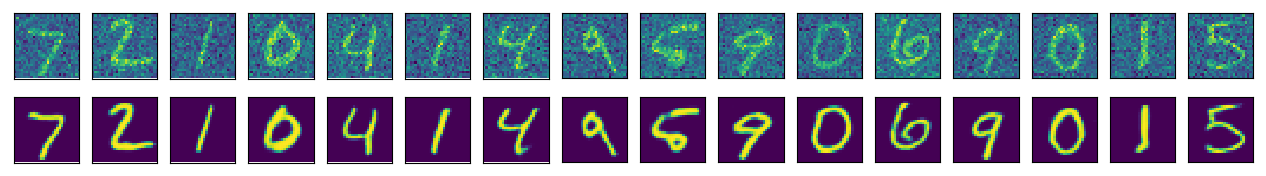

In [398]:
x,y = next(iter(learn.data.val_dl))
z = learn.predict()
compare_batch(x, z)

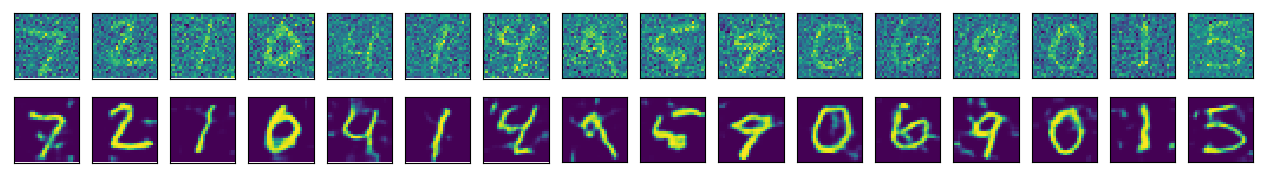

In [399]:
# Higher noise:
def add_noise(tensor, noise_factor=0.5):
    return tensor + noise_factor * torch.randn(tensor.shape)

tfm0 = torchvision.transforms.ToTensor()
tfm1 = torchvision.transforms.Lambda(add_noise)
tfms = torchvision.transforms.Compose([tfm0, tfm1])

learn.data.trn_ds.transform = tfms
learn.data.val_ds.transform = tfms

x,y = next(iter(learn.data.val_dl))
z = learn.predict()
compare_batch(x,z)

> It seems to work pretty well. If you scale this process to a bigger convnet, you can start building document denoising or audio denoising models. [Kaggle has an interesting dataset to get you started](https://www.kaggle.com/c/denoising-dirty-documents).

## 6. Sequence–to–sequence autoencoder

> If your inputs are sequences, rather than vectors or 2D images, then you may want to use as encoder and decoder a type of model that cna capture temporal structure, such as a LSTM. To build a LSTM-based autoencoder, first use a LSTM encoder to turn your input sequences into a single vector that contains information about the entire sequence, then repeat this vector `n` times (where `n` is the number of timesteps in the output sequence), and run a LSTM decoder to turn this constant sequence into the target sequence.
>
> We won't by demonstrating that one on any specific dataset. We will just put a code example for future reference for the reader!

```
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model

inputs = Input(shape=(timesteps, input_dim)
encoded = LSTM(latent_dim)(inputs)(inputs)

decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(input_dim, return_sequences=True)(decoded)

sequence_autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)
```

I don't know how the 'repeating' of Keras RNNs translates into Pytorch RNNs: whether that's simply a stack of RNNs atop of one another (pytorch: `num_layers=n`), or what.

FChollet's RNN starts with a shape: `(timesteps, input_dim)`, so if we go by batch that's `(timesteps, bs, 28, 28, 1)`, and it outputs a shape: `(latent_dim)`.

*But*, the way he has his encoded tensor defined: it's an LSTM outputting shape `(latent_dim)` applied to `inputs`, *applied to* `inputs`.

So that means he's applying the RNN to the input twice.. but then what's the purpose of `timesteps`? So there's a difference between a timestep and how many times an RNN runs on a tensor? I thought that was the same thing.

The decoded tensor is the result of applying `RepeatVector` –– which [acc. to Keras' docs](https://keras.io/layers/core/#repeatvector) just repeats the input `n` times. So given an input tensor of `(n_samples, features)` and `n`, it'll return a tensor of `(n_samples, n, features)`. *hmm* –– with `n = timesteps` to the encoded tensor.. meaning `decoded` is now of shape `(batchsize, timesteps, latent_dim)` *I think*..

The decoded tensor then becomes the result of applying an LSTM with output shape `input_dim` and set to `return_sequences=True` on itself.

Then the full sequence autoencoder is a Model wrapper applied to the input and that final decoded tensor; the encoder is to input & the encoded tensor.

...Right.

I'm going to come back to this after I have more practice with RNNs in Pytorch.

## 7. Variational autoencoder (VAE)

>Variational autoencoders are a slightly more modern and interesting take on autoencoding.

>What is a variational autoencoder, you ask? It's a type of autoencoder with added constraints on the encoded representations being learned. More precisely, it is an autoencoder that learns a [latent variable model](https://en.wikipedia.org/wiki/Latent_variable_model) for its input data. So intead of letting your neural network learn an arbitrary function, you are learning the parameters of a probability distribution modeling your data. If you sample points from this distribution, you can generate new input data samples: a VAE is a "generative model".

>How does a variational autoencoder work?

>First, an encoder network turns the input samples `x` into two parameters in a latent space, which we will note `z_mean` and `z_log_sigma`. Then, we randomly sample similar points `z` from the latent normal distribution that is assumed to generate the data, via `z = z_mean + exp(z_log_sigma) * epsilon`, where the `epsilon` is a random normal tensor. Finally, a decoder network maps these latent space points back to the original input data.

>The parameters of the model are trained via two loss functions: a reconstruction loss forcing the decoded samples to match the initial inputs (just like in our previous autoencoders), and the KL divergence between the learned latent distribution and the prior distribution, acting as a regularization term. You could actually get rid of this latter term entirely, although it does help in learning well-formed latent spaces and reducing overfitting to the training data.

>Because a VAE is a more complex example, we have made the code available on Github as [a standalone script](https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py). Here we will review step by step how the model is created.

>First, here's our encoder network, mapping inputs to our latent distribution parameters:

```
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)
```

> We can use these parameters to sample new similar points from the latent space:

```
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., std=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon
    
# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
```

>Finally, we can map these sampled latent points back to the reconstructed inputs:

```
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)
```

>What we've done so far allows us to instantiate 3 models:
> - an end-to-end autoencoder mapping inputs to reconstructions
> - an encoder mapping inputs to the latent space
> - a generator that can take points on the latent space and will output the corresponding reconstructed samples.

```
# end-to-end autoencoder
vae = Model(x, x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)
```

>We train the model using the end-to-end model, with a custom loss function: the sum of a reconstruction term, and the KL divergence regularization term.

```
def vae_loss(x, x_decoded_mean):
    xent_loss = objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = -0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss
    
vae.compile(optimizer='rmsprop', loss=vae_loss)
```

So this is a VAE with simple linear layers? *Yay* my laptop will enjoy that (I forgot to time it, but the Conv-denoising 100 epoch training session took... *hours*).

In [21]:
class VEncoder(nn.Module):
    """Returns intermediate encodings, mean, and log(stdev) tensors."""
    def __init__(self, input_size, interm_size, latent_size):
        super().__init__()
        self.intermediate = nn.Linear(input_size,  interm_size)
        self.mean_layer   = nn.Linear(interm_size, latent_size)
        self.stdv_layer   = nn.Linear(interm_size, latent_size)
    
    def forward(self, x):
        x     = F.relu(self.intermediate(x))
        μ     = F.relu(self.mean_layer(x)) # Mean vector
        log_σ = F.relu(self.stdv_layer(x)) # Stdv vector
        return x, μ, log_σ

class VSampler(nn.Module):
    """
        Multiplies standard deviation vector by a ~N(0,1) Gaussian distribution.
        Returns mean + new stdev.
        For theory see: https://youtu.be/uaaqyVS9-rM?t=19m42s
    """
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        μ, log_σ = x 
        std_norm = torch.randn(μ.shape) # should I set `requires_grad=True`?
        return μ + torch.exp(log_σ)*std_norm

class VDecoder(nn.Module):
    """Decodes sampled """
    def __init__(self, output_size, interm_size, latent_size):
        super().__init__()
        self.intermediate = nn.Linear(latent_size, interm_size)
        self.out          = nn.Linear(interm_size, output_size)
    
    def forward(self, x):
        x = F.relu(self.intermediate(x))
        x = F.sigmoid(self.out(x))
        return x
        
class VariationalAutoencoder(nn.Module):
    def __init__(self, orign_shape=784, interm_shape=32, latent_shape=16):
        super().__init__()
        self.encoder = VEncoder(orign_shape, interm_shape, latent_shape)
        self.sampler = VSampler()
        self.decoder = VDecoder(orign_shape, interm_shape, latent_shape)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)         # flatten
        enc_x, *μ_log_σ = self.encoder(x) # encode
        x = self.sampler(μ_log_σ)         # sample
        x = self.decoder(x)               # decode
        x = x.reshape(x.size(0),1,28,28)  # 'unflatten' -- could I use x.view(..)?
        return x, μ_log_σ, enc_x

FastAI splits the models output, and calculates the 'raw loss' (via the learner's criterion on the 1st element. If a regularization function is available, the loss is calculated by passing the 1st element of the output, the rest of the output, and the raw loss to that function. (see [`Stepper.step` in fastai/model.py](https://github.com/fastai/fastai/blob/master/fastai/model.py#L48))

So the custom loss function I want has to be compatible with that. I can't just assign my criterion to a function because apparently KL divergence requires the Mean & LogStdev vectors computed by the encoder.

I can have my VAE's forward function hold on to those values and output them, and just deconstruct accordingly in my loss function. BCE will've already've been calculated as 'raw loss', so I can just add that to the KL divergence.

In [22]:
# for kl loss code see: https://wiseodd.github.io/techblog/2017/01/24/vae-pytorch/
# another kl loss (-Σ instead of +Σ: https://github.com/pytorch/examples/blob/master/vae/main.py#L77
# way from keras: https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py#L183

def vae_loss(z, xtra, raw_loss):
    μ_log_σ, _ = xtra
    μ, log_σ   = μ_log_σ
    reconstruction_loss = raw_loss
    kl_divergence_loss  = 0.5 * torch.sum(torch.exp(log_σ) + μ**2 - 1. - log_σ)
    return reconstruction_loss + kl_divergence_loss

In [25]:
# reset ModelData's dataset to not be noisy
tfm0 = torchvision.transforms.ToTensor()
md.trn_ds.transform = md.val_ds.transform = tfm0

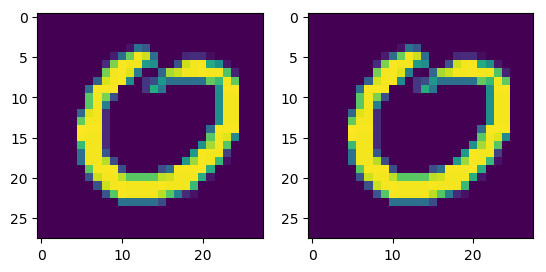

In [407]:
# check
x,y = next(iter(md.trn_dl))
compare_plot(x,y)

In [26]:
learn = Learner.from_model_data(VariationalAutoencoder(), md)

learn.opt_fn = torch.optim.Adadelta
learn.crit   = F.binary_cross_entropy
learn.reg_fn = vae_loss

epoch      trn_loss   val_loss                                 
    0      0.264633   0.264753  



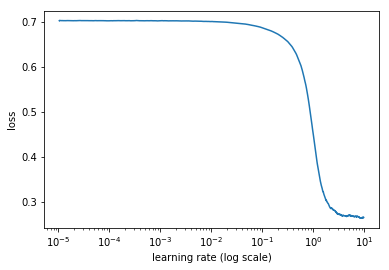

In [27]:
learn.lr_find()
learn.sched.plot()

Looks like [the Keras example](https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py#L126) trains for 50 epochs and has a latent-dimension side of 2. *Oops*. *really?* only 2? Heh, but the intermediate dimension is 512... I'm doing.. *32*. Ehh. Let's see what happens. (**note**: I changed the interm dim later)

In [28]:
learn.fit(0.15, 50) # 50 1-epoch cycles at lr=0.15

epoch      trn_loss   val_loss                                 
    0      0.280115   0.276759  
    1      0.266848   0.266954                                 
    2      0.267701   0.264851                                 
    3      0.263734   0.264014                                 
    4      0.263267   0.263525                                 
    5      0.264164   0.263301                                 
    6      0.263229   0.263083                                 
    7      0.262408   0.262991                                 
    8      0.260605   0.262933                                 
    9      0.263024   0.26285                                  
    10     0.26458    0.262778                                  
    11     0.262448   0.26275                                   
    12     0.262691   0.262752                                 
    13     0.263262   0.262722                                  
    14     0.263677   0.26272                                   
   

[0.2625357766866684]

In [29]:
learn.save('variational_autoencoder_50ep')

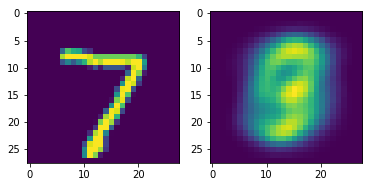

In [32]:
x,y = next(iter(learn.data.val_dl))
z = learn.predict()
compare_plot(x, z)

In [53]:
len(test_loader.dataset[0])

2

In [54]:
enc_x.shape

torch.Size([16, 32])

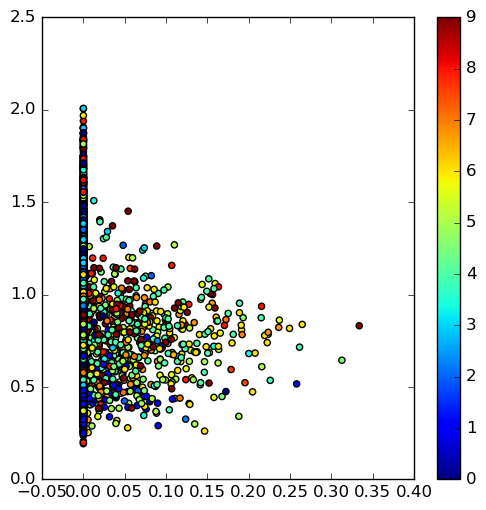

In [67]:
plt.figure(figsize=(6,6)); plt.style.use('classic');

for x,y in iter(test_loader):
    z, μσ, enc_x = learn.model(x)
    
    plt.scatter(enc_x.detach()[:,0], enc_x.detach()[:,1], c=y); 
plt.colorbar();

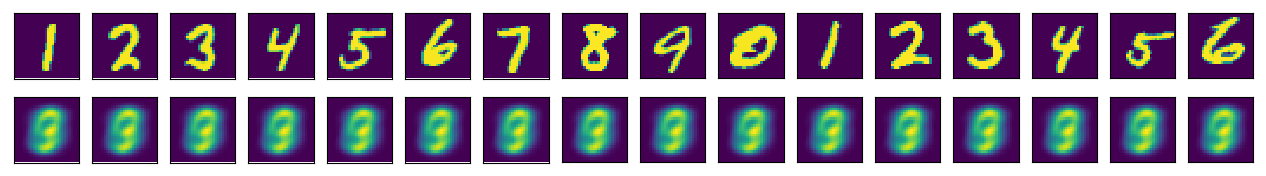

In [70]:
plt.style.use('default')
compare_batch(x.detach(), z.detach())

Looks like it's still too early in training.

epoch      trn_loss   val_loss                                 
    0      0.264716   0.264452  



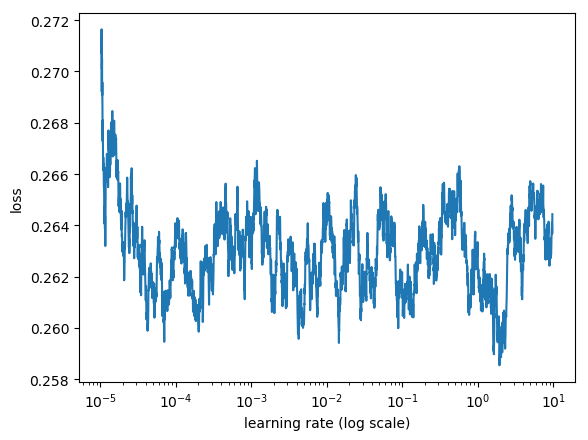

In [71]:
learn.lr_find()
learn.sched.plot()

Oh dear. That's not what you want to see from your LR Finder.

Another training run didn't go anywhere, val loss hit a wall at about 0.2625. What if I increase the 'latent dimension'?

***Wait***... Your Sampler is pulling a Mean and Standard Deviation right? And the Decoder uses that μ & σ to generate a blahblahblah.. So... *why* on Earth do I have the vector my Sampler is pulling from be 32 long? *And* if the 'hidden' (I'm calling it 'intermediate') output (activations) are what the μ- and σ-NN's pull from.. and it's length is 16...

wouldn't that mean that...

*I'm asking my NN to learn to generate values based on a Mean and Standard-Deviation encoded in a 32-long vector, which is built from 2 32-long vectors, which I expect one of which to learn to encode a Mean and the other a Log-Standard Deviation, both from a single 16-long vector....*

***Yeah.*** *No wonder the model couldn't find a way past the minimum it came to. It's a wonder it can figure out '3-ish' in the first place.*

I'm also learning to build an intuition with neural nets.. and it's really cool to see it take shape.

...

Long story short that did not help. I'm going to troubleshoot this in another notebook and come back when I get the loss well below 0.26 (I'm looking for 0.09).

In [37]:
class VEncoder(nn.Module):
    """Returns intermediate encodings, mean, and log(stdev) tensors."""
    def __init__(self, input_size, interm_size, latent_size):
        super().__init__()
        self.intermediate = nn.Linear(input_size,  interm_size)
        self.mean_layer   = nn.Linear(interm_size, latent_size)
        self.stdv_layer   = nn.Linear(interm_size, latent_size)
    
    def forward(self, x):
        x     = F.relu(self.intermediate(x))
        μ     = F.relu(self.mean_layer(x)) # Mean vector
        log_σ = F.relu(self.stdv_layer(x)) # Stdv vector
        return x, μ, log_σ

class VSampler(nn.Module):
    """
        Multiplies standard deviation vector by a ~N(0,1) Gaussian distribution.
        Returns mean + new stdev.
        For theory see: https://youtu.be/uaaqyVS9-rM?t=19m42s
    """
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        μ, log_σ = x 
#         std_norm = torch.randn(μ.shape) # should I set `requires_grad=True`?
#         return μ + torch.exp(log_σ)*std_norm
        σ   = torch.exp(0.5*log_σ)
        eps = torch.randn_like(σ)
        return eps.mul(σ).add_(μ)

class VDecoder(nn.Module):
    """Decodes sampled """
    def __init__(self, output_size, interm_size, latent_size):
        super().__init__()
        self.intermediate = nn.Linear(latent_size, interm_size)
        self.out          = nn.Linear(interm_size, output_size)
    
    def forward(self, x):
        x = F.relu(self.intermediate(x))
        x = F.sigmoid(self.out(x))
        return x
        
class VariationalAutoencoder(nn.Module):
    def __init__(self, orign_shape=784, interm_shape=32, latent_shape=16):
        super().__init__()
        self.encoder = VEncoder(orign_shape, interm_shape, latent_shape)
        self.sampler = VSampler()
        self.decoder = VDecoder(orign_shape, interm_shape, latent_shape)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)         # flatten
        enc_x, *μ_log_σ = self.encoder(x) # encode
        x = self.sampler(μ_log_σ)         # sample
        x = self.decoder(x)               # decode
        x = x.reshape(x.size(0),1,28,28)  # 'unflatten' -- could I use x.view(..)?
        return x, μ_log_σ, enc_x

def vae_loss(z, xtra, raw_loss):
    # https://github.com/pytorch/examples/blob/master/vae/main.py#L76
    μ_log_σ, _ = xtra
    μ, log_σ   = μ_log_σ
    reconstruction_loss = raw_loss
    KLD = -0.5 * torch.sum(1 + log_σ - μ.pow(2) - log_σ.exp())
    return reconstruction_loss + KLD

In [38]:
# x,y = next(iter(test_loader))

# VariationalAutoencoder()(x)

In [39]:
learn = Learner.from_model_data(VariationalAutoencoder(interm_shape=512, latent_shape=2), md)

learn.opt_fn = torch.optim.Adadelta
learn.crit   = F.binary_cross_entropy
learn.reg_fn = vae_loss

epoch      trn_loss   val_loss                                 
    0      0.267383   0.266424  


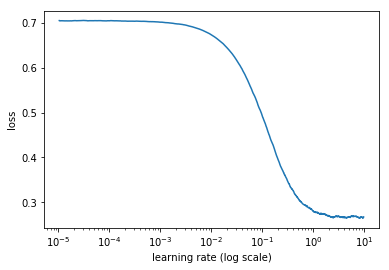

In [40]:
learn.lr_find()
learn.sched.plot()

In [41]:
%time learn.fit(0.1, 10)

epoch      trn_loss   val_loss                                 
    0      0.270458   0.270535  
    1      0.26587    0.265675                                 
    2      0.266665   0.264402                                 
    3      0.26341    0.263858                                 
    4      0.264278   0.26359                                  
    5      0.263515   0.263336                                 
    6      0.264074   0.263247                                 
    7      0.2643     0.263129                                 
    8      0.261996   0.263095                                 
    9      0.263138   0.262987                                 
CPU times: user 46min 51s, sys: 5min 56s, total: 52min 48s
Wall time: 22min 36s


[0.2629868824481964]

In [43]:
learn.save('VAE_eh_10ep')

epoch      trn_loss   val_loss                                 
    0      0.267217   0.265511  


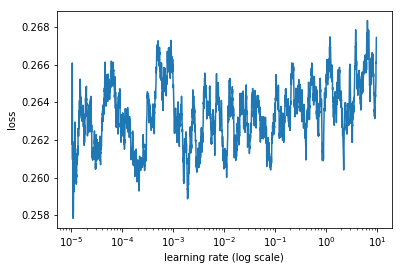

In [44]:
learn.lr_find()
learn.sched.plot()

In [42]:
plt.figure(figsize=(6,6)); plt.style.use('classic');

for x,y in iter(test_loader):
    z, μσ, enc_x = learn.model(x)
    
    plt.scatter(enc_x.detach()[:,0], enc_x.detach()[:,1], c=y); 
plt.colorbar();

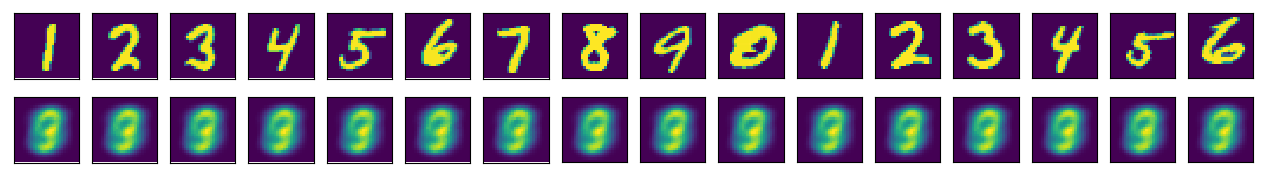

In [78]:
plt.style.use('default')
compare_batch(x.detach(), z.detach())

I can train this architecture in pytorch, but I can't in fastai and I don't know why. Been at it for 2-3 days. I think I'll come back to this notebook later when I figure out why KL loss is magically preventing my network from learning.

>Because our latent space is two-dimensional, there are a few cool visualizations that can be done at this point. One is to look at the neighborhoods of different classes on the latent 2D plane:

```
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6,6)); plt.scatter(x_test[:,0], x_test_encoded[:,1], c=y_test);
plt.colorbar()
```

<img src="https://blog.keras.io/img/ae/vae_classes_plane.png">

>Each of these colored clusters is a type of digit. Close clusters are digits that are structurally similar (i.e. digits that share information in the latent space).

>Because the VAE is a generative model, we can also use it to generate new digits! Here we will scan the latent plane, sampling latent points at regular intervals, and generating the corresponding digit for each of these points. This gives us a visualization of the latent manifold that "generates" the MNIST digits.

```
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * epsilon_std
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10)); plt.imshow(figure);
```

<img src="https://blog.keras.io/img/ae/vae_digits_manifold.png">

## dev work

---

### Aside: tweaking padding to get the right tensor sizes:

In [207]:
# I think I dont need to worry about MaxPool padding bc the tensor's evenly divisible
class ConvEncoder(nn.Module):
    def __init__(self, size=28, encoding_dim=32, n_layers=3):
        super().__init__()
        self.conv0 = nn.Conv2d(1, 16, 3)
        self.conv1 = nn.Conv2d(16, 8, 3)
        self.conv2 = nn.Conv2d(8,  8, 3)
    def forward(self, x):
        x = F.pad(x, (1,1,1,1), mode='replicate') # pad
        x = F.relu(self.conv0(x))                 # conv & actvn
        print(f'Conv1: {x.shape}')
        x = F.max_pool2d(x, 2)                    # pool
        print(f'Pool: {x.shape}')
        x = F.pad(x, (1,1,1,1), mode='replicate') # pad
        x = F.relu(self.conv1(x))                 # conv & actvn
        print(f'Conv1: {x.shape}')
        x = F.max_pool2d(x, 2)                    # pool
        print(f'Pool: {x.shape}')
        x = F.pad(x, (1,1,1,1), mode='replicate') # pad
        x = F.relu(self.conv2(x))                 # conv & actvn
        print(f'Conv2: {x.shape}')
        x = F.pad(x, (1,1,1,1), mode='replicate') # pad
        x = F.max_pool2d(x, 2)                    # pool
        print(f'Pool: {x.shape}')
        return x

In [208]:
encoder = ConvEncoder()
tensor = torch.empty(1,1,28,28)

encoder(tensor).shape

Conv1: torch.Size([1, 16, 28, 28])
Pool: torch.Size([1, 16, 14, 14])
Conv1: torch.Size([1, 8, 14, 14])
Pool: torch.Size([1, 8, 7, 7])
Conv2: torch.Size([1, 8, 7, 7])
Pool: torch.Size([1, 8, 4, 4])


torch.Size([1, 8, 4, 4])

In [242]:
# testing
tesnor = torch.empty(1,1,28,28)
encoded = ConvEncoder()(tensor)
decoded = ConvDecoder()(encoded)

torch.Size([1, 8, 4, 4])
torch.Size([1, 8, 8, 8])
torch.Size([1, 8, 8, 8])
torch.Size([1, 8, 16, 16])
torch.Size([1, 16, 14, 14])
torch.Size([1, 16, 28, 28])
torch.Size([1, 1, 28, 28])


In [212]:
nn.Upsample(scale_factor=2)(tensor).shape

torch.Size([1, 1, 56, 56])

In [208]:
encoder = ConvEncoder()
tensor = torch.empty(1,1,28,28)

encoder(tensor).shape

Conv1: torch.Size([1, 16, 28, 28])
Pool: torch.Size([1, 16, 14, 14])
Conv1: torch.Size([1, 8, 14, 14])
Pool: torch.Size([1, 8, 7, 7])
Conv2: torch.Size([1, 8, 7, 7])
Pool: torch.Size([1, 8, 4, 4])


torch.Size([1, 8, 4, 4])

---

### Aside: PyTorch custom padding

In [116]:
# pytorch padding example: https://pytorch.org/docs/stable/nn.html#torch.nn.functional.pad
t4d = torch.empty(3, 3, 4, 2) # 'empty' tensor
p1d = (1, 1) # pad last dim by 1 on each side
out = F.pad(t4d, p1d, "constant", 0) # effecitvely zero padding
print(out.data.size())
p2d = (1, 1, 2, 2) # pad last dim by (1, 1) and 2nd to last by (2, 2)
out = F.pad(t4d, p2d, "constant", 0)
print(out.data.size())
t4d = torch.empty(3, 3, 4, 2)
p3d = (0, 1, 2, 1, 3, 3) # pad by (0, 1), (2, 1), and (3, 3)
out = F.pad(t4d, p3d, "constant", 0)
print(out.data.size())

torch.Size([3, 3, 4, 4])
torch.Size([3, 3, 8, 4])
torch.Size([3, 9, 7, 3])


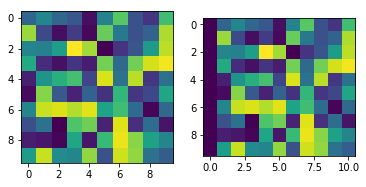

In [135]:
t4d = torch.rand(1,1,10,10)
p1d = (1,0) # +1 to left, +0 to right of last dim
out = F.pad(t4d, p1d, 'constant', 0)
compare_plot(t4d, out)

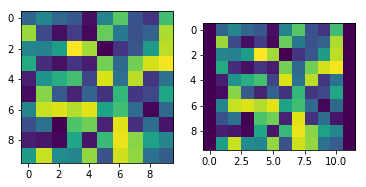

In [136]:
p1d = (1,1) # +1 to both sides of last dim
out = F.pad(t4d, p1d, 'constant', 0) # constant zero pad
compare_plot(t4d, out)

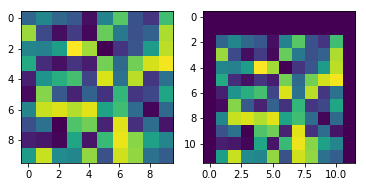

In [146]:
p1d = (1,1, 2,0) # and +2 to top of 2nd-last dim, +0 to bottom
out = F.pad(t4d, p1d, 'constant', 0) # constant zero pad
compare_plot(t4d, out)

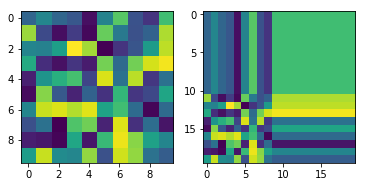

In [149]:
p1d = (0,10, 10,0) # extend right and top by 10
out = F.pad(t4d, p1d, 'replicate') # same padding
compare_plot(t4d, out)

---

### Aside: Creating layers with List Comprehensions:

In [52]:
n_layers=5; encoding_dim = 32; input_size=784

print([encoding_dim * 2**i for i in range(n_layers)])
print([(encoding_dim*2**(i-1), encoding_dim*2**i) for i in range(n_layers)])
print([(encoding_dim*2**i, encoding_dim*2**(i-1)) for i in range(n_layers, 0, -1)])
print([((input_size, encoding_dim*2**i)[i!=n_layers], encoding_dim*2**(i-1)) for i in range(n_layers, 0, -1)])

[32, 64, 128, 256, 512]
[(16.0, 32), (32, 64), (64, 128), (128, 256), (256, 512)]
[(1024, 512), (512, 256), (256, 128), (128, 64), (64, 32)]
[(784, 512), (512, 256), (256, 128), (128, 64), (64, 32)]


In [53]:
[((input_size, encoding_dim*2**i)[i!=n_layers], encoding_dim*2**(i-1)) for i in range(n_layers, 0, -1)]

[(784, 512), (512, 256), (256, 128), (128, 64), (64, 32)]

---

### Aside: calculating μ & σ of MNIST

I wanted some values to normalize the dataset with. I did this by only passing in the `ToTensor()` transfor to the dataset object and turning off shuffling (though that shouldn't matter), then computing the standard deviation & mean.

On second look, FChollet only normalizes to between `[0.0,1.0]`, so this was unnecessary.

In [99]:
%%time
std,mean,count = 0.,0.,0
for x,_ in train_loader:
    std   += torch.std(x)
    mean  += torch.mean(x)
    count += 1
std  /= count
mean /= count

CPU times: user 4.82 s, sys: 17.3 ms, total: 4.84 s
Wall time: 4.86 s


In [100]:
std, mean

(tensor(0.3073), tensor(0.1307))

---

## dev dump

---

So.. what is an "activity_regularizer"? It forces fewer activations to fire... sounds a lot like Dropout.. Ah but he's using L1.. so he's just adding a penalty on activation, not outright killing them. So how to do that in pytorch. First of all looking at [how Keras does it](https://github.com/keras-team/keras/blob/master/keras/regularizers.py#L53):

```
L1 activity regularizer: regularizers.l1
    ––> regularizers.l1:
        ––> def l1(l=0.01):
                return L1L2(l1=l1)
    ––> class L1L2(Regularizer):
            ...
            def __call__(self, x):
                regularization = 0.
                if self.l1:
                    regularization += K.sum(self.l1 * K.abs(x))
                ...
                return regularization
```

Checking the [Keras source code](https://github.com/keras-team/keras/blob/master/keras/layers/core.py#L816) for what the practical difference between activation vs weight regularization is on a `Dense` layer:

```
    ...
    activity_regularizer: Regularizer function applied to 
        the output of the layer (its "activation").
        (see [regularizer](../regularizers.md)).
    ...
```

Ah, so it's just L1 (`sum(l1 * abs(x))`) on the output. How does that talk to the optimizer though? It has to affect the loss value somehow.

Oh, duh. You [just edit the loss function](https://stackoverflow.com/a/47196174) to now take this L1 loss term. Just checking [fast.ai for how that's implemented](https://github.com/fastai/fastai/blob/master/courses/dl2/pascal-multi.ipynb) again
 (we did exactly this for multi-object detection –– see the "Train" section).
 

Looks like in PyTorch we create a function and assign it to the Fast AI Learner's `.crit` (see `ssd_loss` defn). Also looks like you can create an `nn.Module` class that acts on an input like any other NN. I really like pytorch's flexibility.

Although if I define it as a class, I could directly assign the `l1` multiplier to use via `learn.crit.l1 = ..`. If that becomes a problem I'll 'upgrade' it.

**Edit**: No, no. I got mistaken and started looking at implementing L1 *Loss*. I wanted L1 *Regularization*, which is just a penalty tacked onto the loss value. Luckily adding a regularizer is easy [in pytorch](https://stackoverflow.com/questions/44641976/in-pytorch-how-to-add-l1-regularizer-to-activations) and fastai.

In [292]:
def bce_l1_loss(pred, targ, l1=1e-4):
    return F.binary_cross_entropy(pred, targ) + l1*F.l1_loss(pred, targ)

In [288]:
learn.crit

<function torch.nn.functional.binary_cross_entropy(input, target, weight=None, size_average=True, reduce=True)>

In [293]:
learn.crit = bce_l1_loss

In [294]:
learn.crit

<function __main__.bce_l1_loss(pred, targ, l1=0.0001)>

*Ohh*. I just noticed: the L1 Loss FChollet is using is *on the Encoder*. So I can't just put it on the end of my Autoencoder. This isn't hard. I just have to change the model's architecture to output an L1 loss from the encoder in addition to what was going on before:

---

In [211]:
autoencoder = Autoencoder()

In [212]:
%time train(autoencoder, trainloader=train_loader, valloader=test_loader)

Epoch 1/1
----------
train loss 0.199573
valid loss 0.147295
CPU times: user 41.7 s, sys: 1.15 s, total: 42.9 s
Wall time: 15.8 s


In [213]:
x,y = next(iter(train_loader))

In [214]:
z = autoencoder(x)

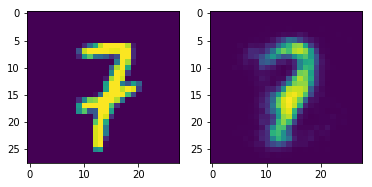

In [215]:
compare_plot(x, z, idx=0)

In [216]:
%time train(autoencoder, trainloader=train_loader, valloader=test_loader, num_epochs=2)

Epoch 1/2
----------
train loss 0.131929
valid loss 0.117059
Epoch 2/2
----------
train loss 0.111982
valid loss 0.105339
CPU times: user 1min 26s, sys: 3.22 s, total: 1min 30s
Wall time: 35.4 s


In [218]:
%time train(autoencoder, trainloader=train_loader, valloader=test_loader, num_epochs=2)

Epoch 1/2
----------
train loss 0.104650
valid loss 0.100961

Epoch 2/2
----------
train loss 0.101456
valid loss 0.098749

CPU times: user 1min 23s, sys: 2.31 s, total: 1min 25s
Wall time: 31.3 s


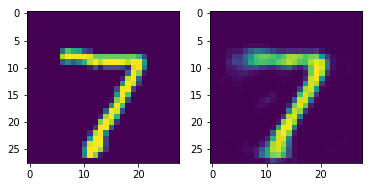

In [220]:
x,y = next(iter(test_loader))
z   = autoencoder(x)
compare_plot(x,z)

---

In [131]:
type(x[0][0])

torch.Tensor

In [130]:
type(z[0][0])

numpy.ndarray

---

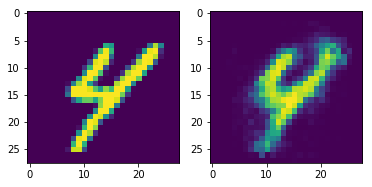

In [212]:
compare_plot(x,z,idx=1)

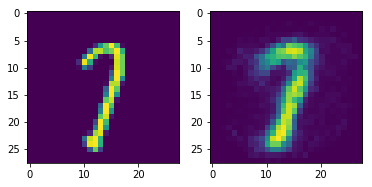

In [213]:
compare_plot(x,z,idx=2)

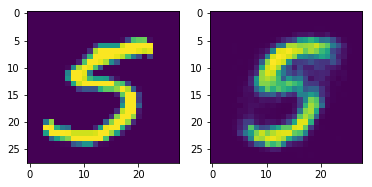

In [214]:
compare_plot(x,z,idx=3)

In [22]:
tmp = copy.deepcopy(train_loader)

In [23]:
tmp.dataset.train_labels = tmp.dataset.train_data

In [84]:
x,y = next(iter(tmp))

In [82]:
(y[0].type(torch.FloatTensor)/255)[8,:20], x[0][0,8,:20]

(tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.2471,  0.9412,  0.9882,  0.9882,  0.9882,  0.5490]),
 tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.2471,  0.9412,  0.9882,  0.9882,  0.9882,  0.5490]))

In [85]:
tmp.dataset.train_labels = tmp.dataset.train_data.type(torch.FloatTensor)/255

In [86]:
x,y = next(iter(tmp))

In [89]:
torch.equal(x[0][0], y[0])

True

In [91]:
tmp.dataset.train_labels.shape, tmp.dataset.train_data.shape

(torch.Size([60000, 28, 28]), torch.Size([60000, 28, 28]))

---

In [102]:
tmp.dataset.train_labels = tmp.dataset.train_labels.reshape((60000,1,28,28))

In [122]:
z = learn.predict()

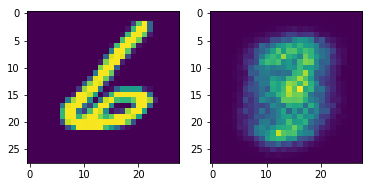

In [133]:
compare_plot()

---

In [181]:
x[0].shape

torch.Size([28, 28])

In [136]:
test_loader.dataset.test_labels.shape

torch.Size([10000])

In [137]:
len(train_loadermd.dataset)

10000

In [93]:
from fastai.conv_learner import *

In [108]:
md = ModelData('data/MNIST', tmp, tmp)

In [109]:
learn = Learner.from_model_data(autoencoder, md)
learn.crit = F.binary_cross_entropy

epoch      trn_loss   val_loss                                  
    0      0.145403   0.166833  


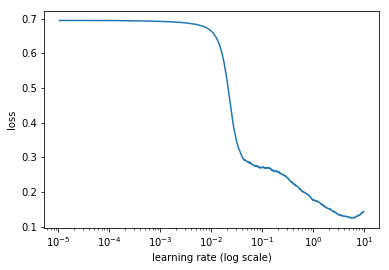

In [110]:
learn.lr_find()
learn.sched.plot()

In [121]:
learn.fit(0.01, 1)

epoch      trn_loss   val_loss                                 
    0      0.260972   0.262096  


[0.2620958075960477]